In [ ]:
from dataclasses import dataclass
import json
import numpy as np
from typing import Callable, List
from matplotlib import pyplot as plt

EPS = 4e-7

# uploading the file
with open('raw.chartblock.json') as f:
    VALUES = json.load(f)

In [ ]:
@dataclass(frozen=True)
class Capital:
  money: float   # suggest cash
  inventory: int # suggest stocks (stonks ;))

def buy(current: Capital, price: List[float]) -> Capital:
  stock_change = current.money // price[0]
  new_cash = current.money - stock_change * price[0]
  new_stocks = current.inventory + stock_change
  return Capital(new_cash, new_stocks)

def sell(current: Capital, price: List[float]) -> Capital:
  new_cash = current.money + current.inventory * price[0]
  new_stocks = 0
  return Capital(new_cash, new_stocks)

#

In [ ]:
# counting total profit according to selected strategy
def income(values, strategy: Callable[[Capital, List[float], List[float]], Capital],
                window: int) -> float:

    bid_iter = [bid[1] for bid in values[0]["ticks"]].__iter__()
    ask_iter = [ask[1] for ask in values[1]["ticks"]].__iter__()

    capital = Capital(money=1, inventory=0)
    try:
        ask_window = [ask_iter.__next__() for _ in range(window)]
        bid_window = [bid_iter.__next__() for _ in range(window)]
        while True:
            capital = strategy(capital, ask_window, bid_window)
            (_, *ask_window) = (*ask_window, ask_iter.__next__())
            (_, *bid_window) = (*bid_window, bid_iter.__next__())
    except StopIteration:
        capital = sell(capital, [max(bid_window)])

    return capital.money

In [ ]:
def best_in_window(capital: Capital, ask: List[float], bid: List[float]) -> Capital:
    delta_bid = bid[1] - bid[0]
    delta_ask = ask[1] - ask[0]
    # if price doesn't change - return
    if (abs(delta_ask) + abs(delta_bid) < 2 * EPS):
      return capital

    best_ask_in_window = min(ask)
    best_bid_in_window = max(bid)
    ask_pos = np.argmin(ask)
    bid_pos = np.argmax(bid)

    if best_bid_in_window - best_ask_in_window > 0:
      if (bid_pos > ask_pos and ask_pos == 0):
        return buy(capital, ask)
    if (bid_pos == 0):
      return sell(capital, bid)

    return capital

print("Total money =", income(VALUES, best_in_window, 14), "$")

Total money = 1.518664000000003 $


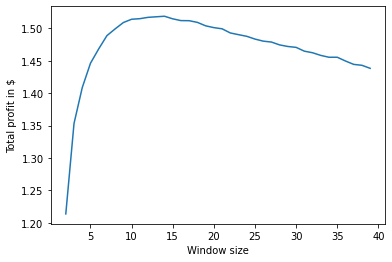

Optimal window is = 14


In [ ]:
# Prove that window = 14 is optimal

total_money = []
window_size = []
for i in range(2, 40):
    total_money.append(income(VALUES, best_in_window, i))
    window_size.append(i)
plt.plot(window_size, total_money)
plt.xlabel("Window size")
plt.ylabel("Total profit in $")
plt.show()

print("Optimal window is =", window_size[np.argmax(total_money)])